# Model Inference
Infer from a cosmological model via MCMC samplers. 

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='0.66' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)

from functools import partial
from getdist import plots
from numpyro import infer

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save
from montecosmo.script import from_id, get_mcmc, get_init_mcmc, get_sqrt_diag_cov_from_numpyro

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb/

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname

feynmangpu04.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Config and fiduc

In [2]:
################## TO SET #######################
# task_id = int(os.environ['SLURM_ARRAY_TASK_ID'])
# m, ev, lo, rsdb, pc, samp, mm
task_id = 2111231
print("SLURM_ARRAY_TASK_ID:", task_id)
model, mcmc_config, save_dir, save_path = from_id(task_id)
os.makedirs(save_dir, exist_ok=True)
print("save path:", save_path)

# import sys
# tempstdout, tempstderr = sys.stdout, sys.stderr
# sys.stdout = sys.stderr = open(save_path+'.out', 'a')
# job_id = int(os.environ['SLURM_ARRAY_JOB_ID'])
# print("SLURM_ARRAY_JOB_ID:", job_id)
# print("SLURM_ARRAY_TASK_ID:", task_id)
# print("jax_enable_x64:", jconfig.read("jax_enable_x64"))

SLURM_ARRAY_TASK_ID: 2111231
save path: /feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_ao0.5_evlpt_lo1_pckaiser_obfield_nob/sMCLMC_nc4_ns64


# CONFIG
{'a_obs': 0.5,
 'box_shape': array([160., 160., 160.]),
 'evolution': 'lpt',
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.06},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'loc_fid': 1.0,
                    'scale': 0.5,
                    'scale_fid': 0.5},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'loc_fid': 0.0,
                    'scale': 2.0,
                    'scale_fid': 2.0},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
   

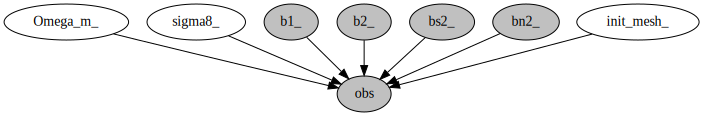

In [3]:
print(model)
print(mcmc_config)
# model.render()

if not os.path.exists(save_dir+"truth.p"):
    # Predict and save fiducial
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1.,
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}
    
    if model.loc_fid['b1'] == 0:
        truth['b1'] = 0.

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    
    print(f"Saving model and truth at {save_dir}")
    model.save(save_dir+"model.p")    
    pdump(truth, save_dir+"truth.p")
else:
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")

model.reset()
if model.loc_fid['b1'] == 0:
    print('no bias')
    model.condition({'obs': truth['obs'], 'b1': truth['b1'], 'b2': truth['b2'], 'bs2': truth['bs2'], 'bn2': truth['bn2']}, frombase=True)
    # model.condition({'obs': truth['obs'], 'bn2': truth['bn2']}, frombase=True)
else:
    model.condition({'obs': truth['obs']})
model.block()
model.render()

## Run

### NUTS, HMC

In [4]:
continue_run = False
if continue_run:
    pass
else:
    model.reset()
    model.condition({'obs': truth['obs']} | model.loc_fid, frombase=True)
    model.block()

    mcmc = get_init_mcmc(model.model, mcmc_config['n_chains'])    
    init_params_ = jit(vmap(partial(model.init_model, delta_obs=truth['obs']-1)))(jr.split(jr.key(45), mcmc.num_chains))
    # init_params_ = model.predict(45, samples=mcmc.num_chains, hide_samp=False)
    
    if not os.path.exists(save_path + "_init_last_state.p"):
        print("# Warmupping...")
        init_mesh_ = {k: init_params_[k] for k in ['init_mesh_']} # NOTE: !!!!!!!
        mcmc = sample_and_save(mcmc, save_path+'_init', 0, 0, extra_fields=['num_steps'], init_params=init_mesh_)
        ils = mcmc.last_state.z
    else:
        print("# Loading init_last_state")
        ils = pload(save_path + "_init_last_state.p").z
    
    # ils = {k: jnp.broadcast_to(v, (mcmc_config['n_chains'], *jnp.shape(v))) for k, v in truth.items()}
    # ils = {k+'_': ils[k+'_'] for k in ['Omega_m','sigma8','b1','b2','bs2','bn2','init_mesh']}

    # ################
    # from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh
    # mesh0 = jnp.fft.irfftn(truth['init_mesh'])
    # kptcs__ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_)
    # kptcs_ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_ | ils)
    # kpk0 = model.spectrum(mesh0)
    # kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)
    # kpkobs = model.spectrum(truth['obs']-1)
    
    # print(ils.keys(), init_params_.keys())

    # mse__ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_)['init_mesh']  - mesh0)**2, axis=(1,2,3))
    # mse_ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_ | ils)['init_mesh']  - mesh0)**2, axis=(1,2,3))
    # print("MSEs:", mse_, mse_)

    # prob = 0.95
    # plt.figure(figsize=(12, 4))
    # plot_powtranscoh(*jnp.median(jnp.stack(kptcs__), 1), label='init')
    # plot_powtranscoh(*kptcs__, fill=prob)
    # plot_powtranscoh(*jnp.median(jnp.stack(kptcs_), 1), label='warm')
    # plot_powtranscoh(*kptcs_, fill=prob)
    # plt.subplot(131)
    # plot_pow(*kpk0, 'k', label='true')
    # plot_pow(*kpkobs, ':', c='grey', label='obs')
    # plt.legend()
    # plt.subplot(133)
    # plot_coh(kptc_obs[0], kptc_obs[-1], ':', c='grey', label='obs')
    # plt.tight_layout()
    # plt.savefig(save_dir+f'init_glin_{task_id}.png')
    # # plt.savefig(f'init_glin_{task_id}.png')
    # ################    
    
    if model.loc_fid['b1'] == 0:
        print('no bias')
        init_params_ = {k:v for k,v in init_params_.items() if k in ['Omega_m_', 'sigma8_']} | ils
        # init_params_ = {k:v for k,v in init_params_.items() if k in ['Omega_m_', 'sigma8_','b1_','b2_','bs2_']} | ils
    else:
        init_params_ |= ils
        # init_params_ |= mcmc.last_state.z
    print(init_params_.keys())

    sqrt_diag_cov = vmap(partial(get_sqrt_diag_cov_from_numpyro, all=False))(pload(save_path + "_init_last_state.p"), init_params_)
    print(sqrt_diag_cov)

model.reset()
if model.loc_fid['b1'] == 0:
    print('no bias')
    model.condition({'obs': truth['obs'], 'b1': truth['b1'], 'b2': truth['b2'], 'bs2': truth['bs2'], 'bn2': truth['bn2']}, frombase=True)
    # model.condition({'obs': truth['obs'], 'bn2': truth['bn2']}, frombase=True)
else:
    model.condition({'obs': truth['obs']})
model.block()

2025-02-13 09:58:49.324383: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Loading init_last_state
no bias
dict_keys(['Omega_m_', 'sigma8_', 'init_mesh_'])
{'Omega_m_': Array([1., 1., 1., 1.], dtype=float64), 'init_mesh_': Array([[[[1.05577234, 0.78862748, 1.02284209, ..., 1.00798959,
          0.90702868, 1.07464231],
         [0.82689448, 0.74798706, 0.82271953, ..., 1.0951692 ,
          1.06101079, 0.94044179],
         [0.89103609, 0.97720844, 0.92455164, ..., 1.2177895 ,
          0.97022496, 1.23183718],
         ...,
         [0.92405888, 1.00429817, 0.93495739, ..., 0.96809277,
          1.11123051, 1.04911127],
         [0.99269759, 0.6870307 , 0.90083454, ..., 1.27684393,
          1.03581417, 1.23981452],
         [0.90143917, 0.87666977, 0.95894779, ..., 1.17841115,
          1.02761476, 1.14006998]],

        [[0.64870834, 0.75724789, 0.77661112, ..., 0.93134747,
          1.12456631, 1.20445008],
         [0.89324156, 0.78523525, 0.88652284, ..., 1.28171554,
          1.04007574, 1.06754025],
         [0.83394877, 0.99074613, 0.77340449, ...,

(4, 32770)
(4, 32770)
(4, 32770)


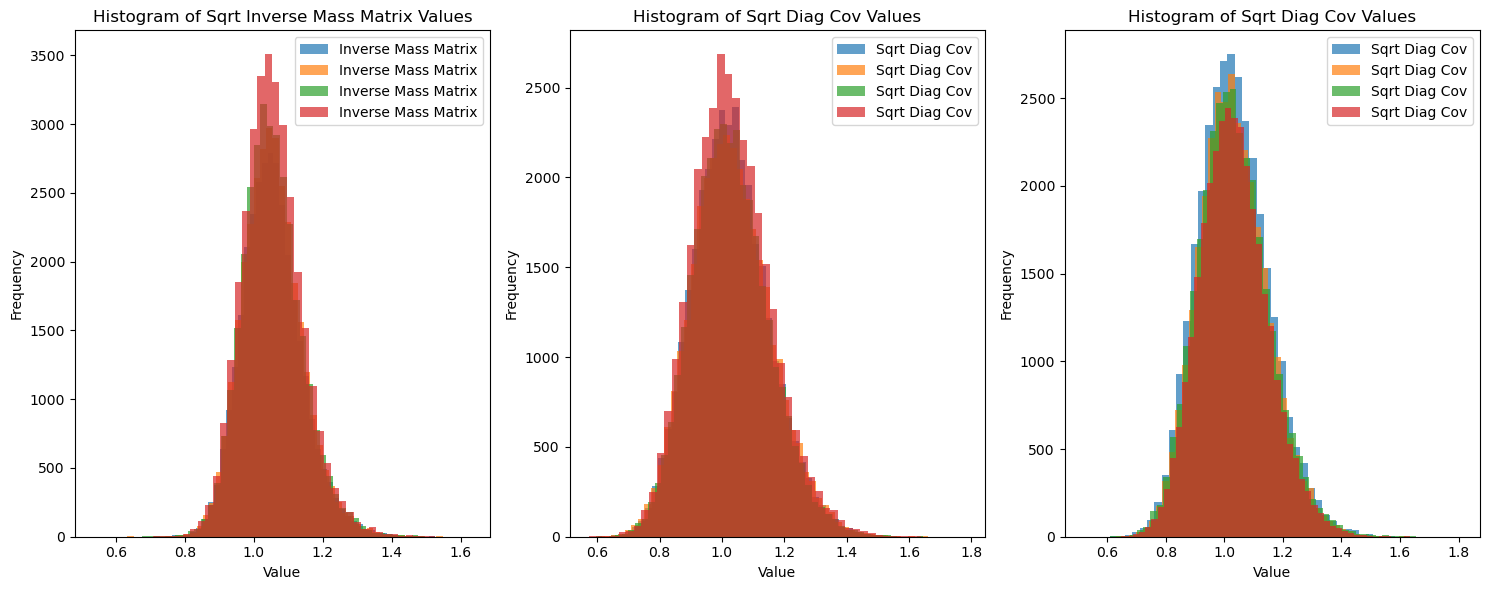

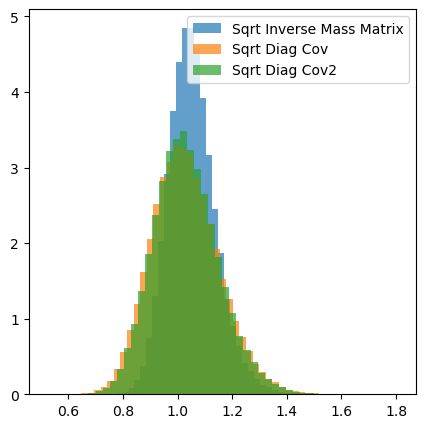

In [18]:
pth = '/feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_ao0.5_evlpt_lo1_pckaiser_obfield_nob/sMCLMC_nc4_ns64_conf.p'
sqrtinvmm = pload(pth).inverse_mass_matrix**.5
from jax.flatten_util import ravel_pytree
@vmap
def unrav(x, proto):
    unravel_fn = ravel_pytree(proto)[1]
    return unravel_fn(x)
sqrtinvmm = unrav(sqrtinvmm, init_params_)

sqrt_diag_cov2= vmap(partial(get_sqrt_diag_cov_from_numpyro, all=True))(pload(save_path + "_last_state.p"), init_params_)
sqrt_diag_cov = vmap(partial(get_sqrt_diag_cov_from_numpyro, all=False))(pload(save_path + "_init_last_state.p"), init_params_)

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
# Histogram of inverse mass matrix values
sqrtinvmm_values = np.concatenate([v.reshape(4,-1) for v in sqrtinvmm.values()], axis=1)
print(sqrtinvmm_values.shape)
for i in range(sqrtinvmm_values.shape[0]):
    axs[0].hist(sqrtinvmm_values[i], alpha=0.7, bins=50, label='Inverse Mass Matrix')
axs[0].set_title('Histogram of Sqrt Inverse Mass Matrix Values')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[0].legend()

# Histogram of sqrt_diag_cov values
sqrt_diag_cov_values = np.concatenate([v.reshape(4,-1) for v in sqrt_diag_cov.values()], axis=1)
print(sqrt_diag_cov_values.shape)
for i in range(sqrt_diag_cov_values.shape[0]):
    axs[1].hist(sqrt_diag_cov_values[i], bins=50, alpha=0.7, label='Sqrt Diag Cov')
axs[1].set_title('Histogram of Sqrt Diag Cov Values')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
axs[1].legend()

# Histogram of sqrt_diag_cov values
sqrt_diag_cov_values2 = np.concatenate([v.reshape(4,-1) for v in sqrt_diag_cov2.values()], axis=1)
print(sqrt_diag_cov_values2.shape)
for i in range(sqrt_diag_cov_values2.shape[0]):
    axs[2].hist(sqrt_diag_cov_values2[i], bins=50, alpha=0.7, label='Sqrt Diag Cov')
axs[2].set_title('Histogram of Sqrt Diag Cov Values')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Frequency')
axs[2].legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.hist(sqrtinvmm_values.flatten(), bins=50, density=True, alpha=0.7, label='Sqrt Inverse Mass Matrix')
plt.hist(sqrt_diag_cov_values.flatten(), bins=50, density=True, alpha=0.7, label='Sqrt Diag Cov')
plt.hist(sqrt_diag_cov_values2.flatten(), bins=50, density=True, alpha=0.7, label='Sqrt Diag Cov2')
plt.legend()
plt.show()

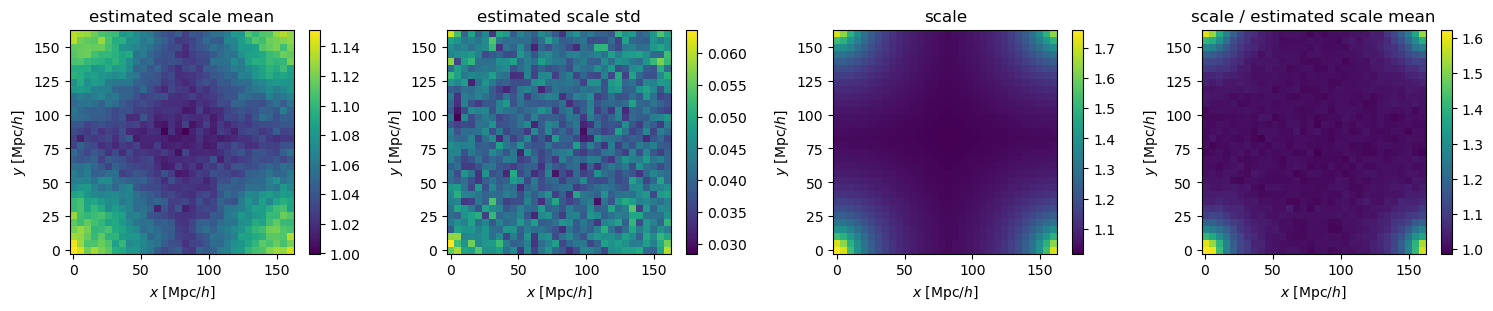

In [28]:
from montecosmo.plot import plot_mesh
from montecosmo.bricks import lin_power_mesh, Planck18
from montecosmo.utils import rg2cgh, cgh2rg
cosmo = Planck18()
scale, transfer = model._precond_scale_and_transfer(cosmo)
scale = rg2cgh(scale, amp=True)
sli = None

plt.figure(figsize=(15, 3), layout='constrained')

est_scale = vmap(partial(rg2cgh, amp=True))(sqrtinvmm['init_mesh_'])
est_scale_mean, est_scale_std = est_scale.mean(0), est_scale.std(0)
plt.subplot(141)
plot_mesh(est_scale_mean, model.box_shape, sli=sli)
plt.title('estimated scale mean')
plt.colorbar()

plt.subplot(142)
plot_mesh(est_scale_std, model.box_shape, sli=sli)
plt.title('estimated scale std')
plt.colorbar()

plt.subplot(143)
plot_mesh(scale, model.box_shape, sli=sli)
plt.title('scale')
plt.colorbar()

plt.subplot(144)
plot_mesh(scale / est_scale_mean, model.box_shape, sli=sli)
plt.title('scale / estimated scale mean')
plt.colorbar()

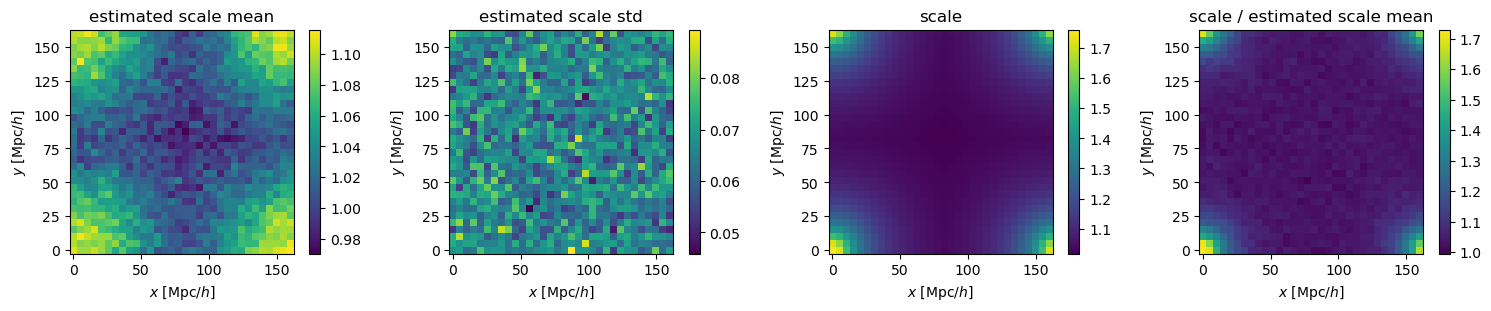

In [31]:
from montecosmo.plot import plot_mesh
from montecosmo.bricks import lin_power_mesh, Planck18
from montecosmo.utils import rg2cgh, cgh2rg
cosmo = Planck18()
scale, transfer = model._precond_scale_and_transfer(cosmo)
scale = rg2cgh(scale, amp=True)
sli = None

plt.figure(figsize=(15, 3), layout='constrained')

est_scale = vmap(partial(rg2cgh, amp=True))(sqrt_diag_cov['init_mesh_'])
est_scale_mean, est_scale_std = est_scale.mean(0), est_scale.std(0)
plt.subplot(141)
plot_mesh(est_scale_mean, model.box_shape, sli=sli)
plt.title('estimated scale mean')
plt.colorbar()

plt.subplot(142)
plot_mesh(est_scale_std, model.box_shape, sli=sli)
plt.title('estimated scale std')
plt.colorbar()

plt.subplot(143)
plot_mesh(scale, model.box_shape, sli=sli)
plt.title('scale')
plt.colorbar()

plt.subplot(144)
plot_mesh(scale / est_scale_mean, model.box_shape, sli=sli)
plt.title('scale / estimated scale mean')
plt.colorbar()

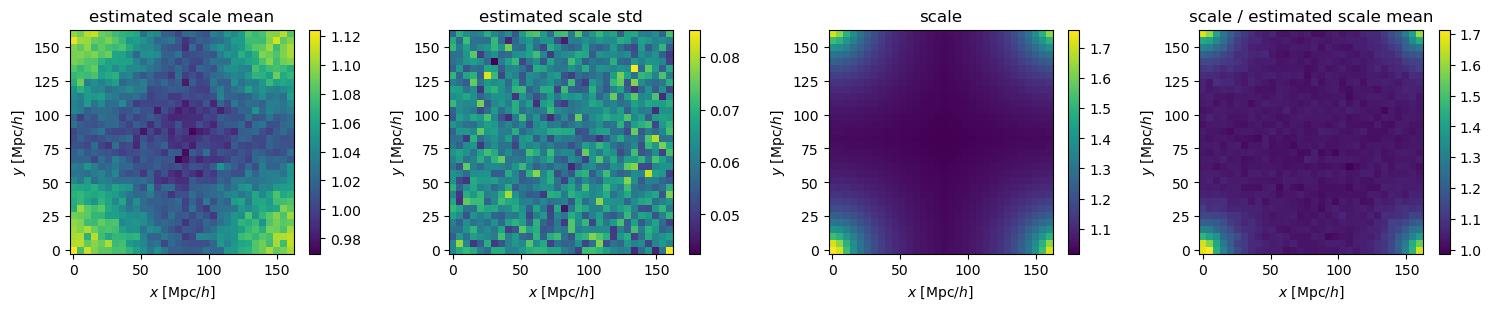

In [30]:
from montecosmo.plot import plot_mesh
from montecosmo.bricks import lin_power_mesh, Planck18
from montecosmo.utils import rg2cgh, cgh2rg
cosmo = Planck18()
scale, transfer = model._precond_scale_and_transfer(cosmo)
scale = rg2cgh(scale, amp=True)
sli = None

plt.figure(figsize=(15, 3), layout='constrained')

est_scale = vmap(partial(rg2cgh, amp=True))(sqrt_diag_cov2['init_mesh_'])
est_scale_mean, est_scale_std = est_scale.mean(0), est_scale.std(0)
plt.subplot(141)
plot_mesh(est_scale_mean, model.box_shape, sli=sli)
plt.title('estimated scale mean')
plt.colorbar()

plt.subplot(142)
plot_mesh(est_scale_std, model.box_shape, sli=sli)
plt.title('estimated scale std')
plt.colorbar()

plt.subplot(143)
plot_mesh(scale, model.box_shape, sli=sli)
plt.title('scale')
plt.colorbar()

plt.subplot(144)
plot_mesh(scale / est_scale_mean, model.box_shape, sli=sli)
plt.title('scale / estimated scale mean')
plt.colorbar()

In [5]:
from tqdm import tqdm
if mcmc_config['sampler'] in ['NUTS', 'HMC']:
    mcmc = get_mcmc(model.model, mcmc_config)
    if continue_run:
        print(f"{jnp.result_type(True)=}") # HACK: why is it working?!!
        mcmc.num_warmup = 0
        mcmc.post_warmup_state = pload(save_path + "_last_state.p")
        start = 3 ###############
        end = start + mcmc_config['n_runs'] - 1
        mcmc_runned = sample_and_save(mcmc, save_path, start, end, rng=44, extra_fields=['num_steps'])

    else:
        # mcmc_runned = sample_and_save(mcmc, save_path, 0, mcmc_config['n_runs'], extra_fields=['num_steps'], init_params=init_params_)
        mcmc_runned = sample_and_save(mcmc, save_path, 0, 0, extra_fields=['num_steps'], init_params=init_params_)
       

elif mcmc_config['sampler'] == 'NUTSWG':
    from montecosmo.samplers import nutswg_init, get_nutswg_warm, get_nutswg_run
    n_samples, n_runs, n_chains = mcmc_config['n_samples'], mcmc_config['n_runs'], mcmc_config['n_chains']

    step_fn, init_fn, conf, init_state_fn = nutswg_init(model.logpdf)

    # warmup_fn = jit(vmap(get_nutswg_warm(model.logpdf, conf, mcmc_config['n_samples'], progress_bar=False)))
    # state = jit(vmap(init_state_fn))(init_params_)

    # samples, infos, state, conf = warmup_fn(jr.split(jr.key(43), n_chains), state)
    # print("conf:", conf,
    #         "\n\ninfos:", infos, '\n#################\n')
    # jnp.savez(save_path+f"_{0}.npz", **samples | {k:infos[k] for k in ['n_evals']})
    # pdump(state, save_path+f"_last_state.p")
    # pdump(conf, save_path+'_conf.p'), pdump(tree.map(jnp.mean, infos), save_path+'_infos.p')

    conf = pload(save_path+'_conf.p')
    state = pload(save_path+'_last_state.p')
    
    run_fn = jit(vmap(get_nutswg_run(model.logpdf, step_fn, init_fn, n_samples, progress_bar=False)))
    start = 1 ######
    end = start + n_runs - 1
    key = jr.key(42)
    for i_run in tqdm(range(start, end+1)):
        print(f"run {i_run}/{end}")
        key, run_key = jr.split(key, 2)
        samples, infos, state = run_fn(jr.split(run_key, n_chains), state, conf)
        print("infos:", tree.map(lambda x: jnp.mean(x, 1), infos))
        jnp.savez(save_path+f"_{i_run}.npz", **samples | {k:infos[k] for k in ['n_evals']})
        pdump(state, save_path+f"_last_state.p")

elif mcmc_config['sampler'] == 'MCLMC':
    from montecosmo.samplers import get_mclmc_warmup, get_mclmc_run
    from jax.flatten_util import ravel_pytree

    if mcmc_config['mm']:
        sdc = ravel_pytree(tree.map(lambda x:x.mean(0), sqrt_diag_cov))[0]
    else:
        sdc = 1.
        
    config = None
    # config = {'L':193, 'step_size': 45,} # 64^3
    # config = {'L':500, 'step_size': 10,} # 64^3 norsdb
    # config = {'L':350, 'step_size': 3,} # 64^3 a=.5
    # config = {'L':700, 'step_size':45, 'inverse_mass_matrix':sdc**2} # 64, 128^3 a=.5

    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_samples=2**15, config=config, desired_energy_var=5e-5, diagonal_preconditioning=True)))
    state, config = warmup_fn(jr.split(jr.key(43), mcmc_config['n_chains']), init_params_)
    pdump(state, save_path+f"_last_state.p")
    pdump(config, save_path+f"_conf.p")

    # state = pload(save_path+f"_last_state.p")
    # config = pload(save_path+f"_conf.p")
    print(config)
    n_samples, n_runs, n_chains = mcmc_config['n_samples'], mcmc_config['n_runs'], mcmc_config['n_chains']

    thinning = 32
    run_fn = jit(vmap(get_mclmc_run(model.logpdf, n_samples, thinning=thinning, progress_bar=False)))

    start = 1 ######
    end = start + n_runs - 1
    key = jr.key(42)
    for i_run in tqdm(range(start, n_runs + start)):
        print(f"run {i_run}/{n_runs}")
        key, run_key = jr.split(key, 2)
        state, samples, info = run_fn(jr.split(run_key, n_chains), state, config)
        
        info = tree.map(lambda x: jnp.mean(x**2, 1), info)
        mse_per_dim = {'mse_per_dim': info.energy_change / model.mesh_shape.astype(float).prod()}
        print(info, "\nmean square energy fluctation per dim:", mse_per_dim, '\n')
        pdump(info, save_path+f"_info.p")

        jnp.savez(save_path+f"_{i_run}.npz", **samples)
        pdump(state, save_path+f"_last_state.p")

Adaptation start: finding L, ss, mm


2025-02-13 10:05:36.697216: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__unnamed_function_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-02-13 10:06:04.959931: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m28.262783044s

********************************
[Compiling module jit__unnamed_function_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-02-13 10:18:04.432741: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


MCLMCAdaptationState(L=Array([194.38962073, 194.21291483, 193.7780447 , 194.35242235], dtype=float64), step_size=Array([35.47177087, 36.1325749 , 32.77120331, 35.59846709], dtype=float64), inverse_mass_matrix=Array([[1.04906877, 0.93722288, 0.93851523, ..., 1.4500167 , 1.34605543,
        0.8502687 ],
       [1.03008124, 1.03567892, 1.01871913, ..., 1.29768659, 1.16143723,
        0.92589671],
       [1.18013787, 0.98268405, 1.44111975, ..., 1.33344337, 1.18880762,
        0.98425788],
       [0.82569906, 1.06821555, 0.89806354, ..., 1.27176848, 1.34937552,
        0.86912076]], dtype=float64))


  0%|          | 0/15 [00:00<?, ?it/s]

run 1/15


  7%|▋         | 1/15 [03:51<54:03, 231.66s/it]

MCLMCInfo(logdensity=Array([1.68370976e+10, 1.68336339e+10, 1.68406771e+10, 1.68410304e+10],      dtype=float64), kinetic_change=Array([1395.54080374, 1452.57059366,  992.46859198, 1402.73144206],      dtype=float64), energy_change=Array([ 3.19512882, 64.40755227,  7.95485414,  1.38485989], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([9.75075933e-05, 1.96556251e-03, 2.42762883e-04, 4.22625700e-05],      dtype=float64)} 

run 2/15


 13%|█▎        | 2/15 [06:06<37:50, 174.65s/it]

MCLMCInfo(logdensity=Array([1.68418931e+10, 1.68399295e+10, 1.68418205e+10, 1.68412789e+10],      dtype=float64), kinetic_change=Array([1332.61111121, 1238.74553927, 1130.13790715, 1409.90721408],      dtype=float64), energy_change=Array([18.7254859 , 14.80909444,  4.11057008,  1.58640666], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([5.71456479e-04, 4.51937697e-04, 1.25444643e-04, 4.84132890e-05],      dtype=float64)} 

run 3/15


 20%|██        | 3/15 [08:21<31:17, 156.44s/it]

MCLMCInfo(logdensity=Array([1.68376372e+10, 1.68405659e+10, 1.68366038e+10, 1.68340197e+10],      dtype=float64), kinetic_change=Array([1673.96484501, 1515.51956237, 1085.17003129, 1379.35072578],      dtype=float64), energy_change=Array([13.9264979 , 20.52631205,  5.84073867,  1.61995607], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([4.25002988e-04, 6.26413332e-04, 1.78245199e-04, 4.94371360e-05],      dtype=float64)} 

run 4/15


 27%|██▋       | 4/15 [10:35<27:06, 147.83s/it]

MCLMCInfo(logdensity=Array([1.68368373e+10, 1.68440880e+10, 1.68375707e+10, 1.68448231e+10],      dtype=float64), kinetic_change=Array([1363.28873318, 1509.09895948, 1213.48856905, 1349.26510185],      dtype=float64), energy_change=Array([7.14460824, 5.25744017, 4.93473492, 1.28174327], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([2.18036140e-04, 1.60444341e-04, 1.50596159e-04, 3.91157004e-05],      dtype=float64)} 

run 5/15


 33%|███▎      | 5/15 [12:50<23:51, 143.11s/it]

MCLMCInfo(logdensity=Array([1.68412798e+10, 1.68340760e+10, 1.68404231e+10, 1.68400877e+10],      dtype=float64), kinetic_change=Array([1318.7283566 , 1272.55729058, 1255.27259121, 1363.05457011],      dtype=float64), energy_change=Array([45.29769703, 11.40179345, 19.36791637,  1.70716328], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([1.38237601e-03, 3.47955122e-04, 5.91061901e-04, 5.20984887e-05],      dtype=float64)} 

run 6/15


 40%|████      | 6/15 [15:05<21:02, 140.23s/it]

MCLMCInfo(logdensity=Array([1.68380465e+10, 1.68372355e+10, 1.68459165e+10, 1.68430232e+10],      dtype=float64), kinetic_change=Array([1502.74488941, 1293.56038219, 1109.9354912 , 1252.09706925],      dtype=float64), energy_change=Array([48.53395665,  5.50891302, 14.68418727,  1.94170686], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([1.48113881e-03, 1.68118683e-04, 4.48125832e-04, 5.92561909e-05],      dtype=float64)} 

run 7/15


 47%|████▋     | 7/15 [17:19<18:27, 138.44s/it]

MCLMCInfo(logdensity=Array([1.68405779e+10, 1.68399853e+10, 1.68386792e+10, 1.68408769e+10],      dtype=float64), kinetic_change=Array([1315.26336342, 1422.77277198, 1246.03322777, 1280.24469497],      dtype=float64), energy_change=Array([ 3.26978423,  6.1644254 , 58.89813443,  1.32554635], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([9.97858956e-05, 1.88123334e-04, 1.79742842e-03, 4.04524642e-05],      dtype=float64)} 

run 8/15
MCLMCInfo(logdensity=Array([1.68414847e+10, 1.68385521e+10, 1.68355833e+10, 1.68385349e+10],      dtype=float64), kinetic_change=Array([1492.85289425, 1502.15370246, 1139.37335334, 1440.20720603],      dtype=float64), energy_change=Array([2.84831677, 2.92973615, 2.01348611, 1.33689844], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([8.69237296e-05, 8.94084518e-05, 6.14467195e-05, 4.07989025e-05],      dtype=float64)} 



 53%|█████▎    | 8/15 [19:34<16:01, 137.35s/it]

run 9/15


 60%|██████    | 9/15 [21:49<13:39, 136.59s/it]

MCLMCInfo(logdensity=Array([1.68433620e+10, 1.68416263e+10, 1.68414560e+10, 1.68364928e+10],      dtype=float64), kinetic_change=Array([1492.3017558 , 1238.50355008, 1056.3884854 , 1515.14238972],      dtype=float64), energy_change=Array([ 3.45431311, 14.06675178,  4.07354744,  2.31954002], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([1.05417270e-04, 4.29283196e-04, 1.24314802e-04, 7.07867437e-05],      dtype=float64)} 

run 10/15
MCLMCInfo(logdensity=Array([1.68344972e+10, 1.68408310e+10, 1.68342202e+10, 1.68428442e+10],      dtype=float64), kinetic_change=Array([1365.16259339, 1373.60399827, 1177.73519083, 1287.98289571],      dtype=float64), energy_change=Array([ 9.29853687, 19.26133545,  1.54983093,  1.66253738], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([2.83768825e-04, 5.87809309e-04, 4.72970864e-05, 5.07366142e-05],      dtype=float64)} 



 67%|██████▋   | 10/15 [24:05<11:20, 136.14s/it]

run 11/15
MCLMCInfo(logdensity=Array([1.68402094e+10, 1.68409005e+10, 1.68413143e+10, 1.68388493e+10],      dtype=float64), kinetic_change=Array([1304.80458114, 1556.35363866, 1267.89156861, 1239.15156923],      dtype=float64), energy_change=Array([ 3.66479018,  9.29043702, 61.0452846 ,  1.38388458], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([1.11840521e-04, 2.83521637e-04, 1.86295424e-03, 4.22328057e-05],      dtype=float64)} 



 73%|███████▎  | 11/15 [26:20<09:03, 135.95s/it]

run 12/15


 80%|████████  | 12/15 [28:35<06:46, 135.63s/it]

MCLMCInfo(logdensity=Array([1.68331856e+10, 1.68394579e+10, 1.68432454e+10, 1.68438838e+10],      dtype=float64), kinetic_change=Array([1279.54360505, 1498.52133748, 1087.88532102, 1355.97382614],      dtype=float64), energy_change=Array([ 3.63943432,  9.31181586, 21.82041932,  1.31139932], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([1.11066721e-04, 2.84174068e-04, 6.65906351e-04, 4.00207313e-05],      dtype=float64)} 

run 13/15


 87%|████████▋ | 13/15 [30:51<04:31, 135.75s/it]

MCLMCInfo(logdensity=Array([1.68359221e+10, 1.68408774e+10, 1.68476721e+10, 1.68407339e+10],      dtype=float64), kinetic_change=Array([1343.36110982, 1524.92454819, 1221.41933767, 1511.14607473],      dtype=float64), energy_change=Array([19.50984489, 81.91332801, 17.32073697,  1.72602495], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([5.95393216e-04, 2.49979639e-03, 5.28586944e-04, 5.26741012e-05],      dtype=float64)} 

run 14/15


 93%|█████████▎| 14/15 [33:06<02:15, 135.47s/it]

MCLMCInfo(logdensity=Array([1.68385738e+10, 1.68399053e+10, 1.68397021e+10, 1.68413276e+10],      dtype=float64), kinetic_change=Array([1430.45802981, 1515.58452541, 1219.90131767, 1554.2801029 ],      dtype=float64), energy_change=Array([12.48876933, 32.21404206,  1.1923777 ,  1.47926058], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([3.81126994e-04, 9.83094545e-04, 3.63884796e-05, 4.51434502e-05],      dtype=float64)} 

run 15/15


100%|██████████| 15/15 [35:20<00:00, 141.40s/it]

MCLMCInfo(logdensity=Array([1.68440831e+10, 1.68377385e+10, 1.68366599e+10, 1.68361563e+10],      dtype=float64), kinetic_change=Array([1585.58476695, 1370.79645169, 1051.2772732 , 1416.21299772],      dtype=float64), energy_change=Array([12.38571302,  5.9595276 ,  1.17384488,  1.9540045 ], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([3.77981965e-04, 1.81870349e-04, 3.58229030e-05, 5.96314850e-05],      dtype=float64)} 



In [5]:
2**14, 4*4096

(16384, 16384)